In [1]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import yfinance
import matplotlib.ticker as mticker
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from mplfinance.original_flavor import candlestick_ohlc


In [2]:
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []

    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):

            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmin())  

    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]

    p = prices.reset_index()   
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['Close']
    
    return max_min

smoothing = 3
window = 10


In [3]:
from collections import defaultdict

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

In [4]:
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['Close']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]  
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['Close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    # for stock in stock_data:
    #     prices = stock_data.iloc[stock]
    prices = stock_data
    for ema_ in ema_list:
        for window_ in window_list: 
            max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
            pat = find_patterns(max_min)
            if plot == True:
                plot_minmax_patterns(prices, max_min, pat, 'AAPL', window_, ema_)
                
            if results == True:
                all_results = pd.concat([all_results, get_results(prices, max_min, pat, 'AAPL', ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

In [5]:
def get_rs_pattern(daf):
    ema_list = [10 , 20 , 50]
    window_list = [10 , 20 , 50]
    resampled_data = daf.resample('60T', closed='right', label='right').agg({'Open': 'first',
                                                                            'High': 'max',
                                                                            'Low': 'min',
                                                                            'Close': 'last'}).dropna()
    results = screener(resampled_data , ema_list , window_list , False, True)
    return results

In [6]:
# Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)


    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)    
    plt.show()

In [7]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)


#Handle
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [8]:
lookback = 80

In [9]:
def pre_processing(df):
    results = get_rs_pattern(df)

    # max_val = 0 #Define the gap dist between each range to make all the input have the same dimension
    # for i in range(len(results)):
    #     if (results.iloc[i].values[4] != None):
    #         x , y = results.iloc[i].values[4]
    #         max_val = max(max_val , y-x)

    cor_arr = [] #Save the x , y as per each range we have with the same dimension width . Eg , (30, max_val  ,4) 
    for i in range(len(results)):
        if (results.iloc[i].values[4] != None):
            x , y = results.iloc[i].values[4]
            if (y-x < lookback):
                gap = lookback - y + x 
                mid = int(gap / 2)
                x = x - mid
                y = y + gap - mid
                cor_arr.append([x,y])


    X_raw_tmp = [] #Array for actual data
    X_tmp = [] #Array for converted data
    Y_tmp = [] #Array for prediction based on the condition whether the mean close value of next two week is higher than current close value

    for row in cor_arr:
        tmp = []
        mean = []
        prediction = 0
        X_raw_tmp.append(df.values[row[0] : row[1]]) # append raw value
        for idx in range(row[0] , row[1]):
            converted_data = ohlc_to_candlestick(df.values[idx])
            tmp.append(converted_data) # convert data to cds 

        for idx in range(row[1], row[1] + 14):
            mean.append(df.values[idx][3])

        X_tmp.append(tmp)
        if (np.mean(mean) > df.values[row[1]][3]):
            prediction = 1
        Y_tmp.append(prediction)

    X_tmp = np.asarray(X_tmp)
    X_raw_tmp = np.asarray(X_raw_tmp)
    Y_tmp = np.asarray(Y_tmp)

    return X_tmp, Y_tmp, X_raw_tmp

X  = np.empty((0,lookback,4))
Y = np.empty((0))
X_raw = np.empty((0,lookback,4))


In [10]:
stocks = ['AAPL' , 'MSFT', 'AMD' , 'FB' , 'AMZN' , 'ADSK' , 'ANSS' ,  'AVGO' , 'AZN' , 'FISV' , 'GILD' , 'KHC' , 'NFLX' , 'OKTA' , 'REGN']
# ,
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 32 )

for stock in stocks:
  df = yfinance.download(stock , startDate , endDate )
  del df['Volume']
  del df['Adj Close']
  X1 , Y1 , X_raw1 = pre_processing(df)
  X = np.concatenate((X, X1) , axis= 0)
  Y = np.concatenate((Y, Y1) , axis= 0)
  X_raw = np.concatenate((X_raw, X_raw1) , axis= 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
X.shape

(182, 80, 4)

In [12]:
Y.shape

(182,)

In [33]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 25,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.1))
model.add(layers.LSTM(units = 50,return_sequences=True ))
model.add(Dropout(0.1))
model.add(layers.LSTM(units = 50))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [34]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5 , shuffle = False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5 , shuffle = False)
X_train_raw, X_val_and_test_raw = train_test_split(X_raw, test_size=0.5 , shuffle = False )
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5 , shuffle = False)


In [35]:
history = model.fit(X_train, Y_train, epochs= 200 ,validation_data=(X_val, Y_val))

Epoch 1/200
3/3 [==============================] - 5s 459ms/step - loss: 0.7159 - acc: 0.5165 - val_loss: 0.6898 - val_acc: 0.5778
Epoch 2/200
3/3 [==============================] - 0s 71ms/step - loss: 0.6806 - acc: 0.5714 - val_loss: 0.7203 - val_acc: 0.4000
Epoch 3/200
3/3 [==============================] - 0s 75ms/step - loss: 0.6577 - acc: 0.6703 - val_loss: 0.6542 - val_acc: 0.6667
Epoch 4/200
3/3 [==============================] - 0s 74ms/step - loss: 0.6420 - acc: 0.6044 - val_loss: 1.0060 - val_acc: 0.2444
Epoch 5/200
3/3 [==============================] - 0s 67ms/step - loss: 0.6735 - acc: 0.6154 - val_loss: 0.8362 - val_acc: 0.2889
Epoch 6/200
3/3 [==============================] - 0s 67ms/step - loss: 0.6375 - acc: 0.6703 - val_loss: 0.6030 - val_acc: 0.7333
Epoch 7/200
3/3 [==============================] - 0s 76ms/step - loss: 0.6443 - acc: 0.5824 - val_loss: 0.7093 - val_acc: 0.5111
Epoch 8/200
3/3 [==============================] - 0s 71ms/step - loss: 0.6387 - acc: 0.6

In [16]:
# model.save('HAS_inversed.h5')

In [17]:
# model = keras.models.load_model('HAS_inversed.h5')

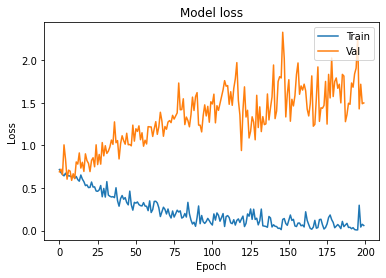

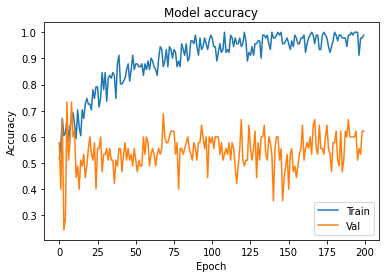

In [36]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 14ms/step - loss: 2.6815 - acc: 0.4348
Test accuracy: 0.43478259444236755


Correct trend is Bullish
Model prediction trend is Bullish
WON


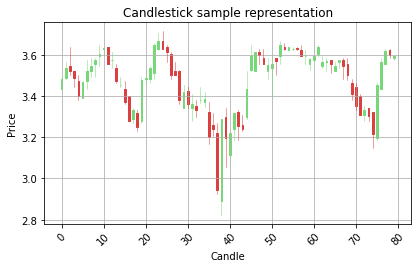

Correct trend is Bearish
Model prediction trend is Bullish
LOST


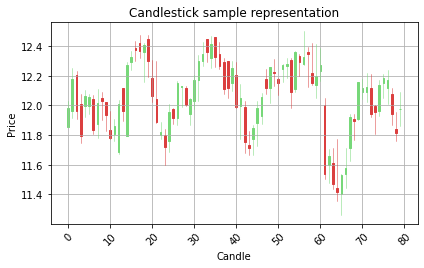

Correct trend is Bearish
Model prediction trend is Bullish
LOST


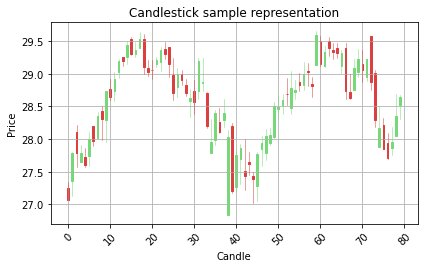

Correct trend is Bullish
Model prediction trend is Bullish
WON


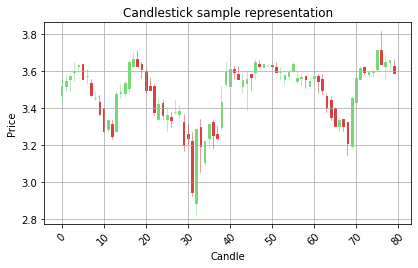

Correct trend is Bullish
Model prediction trend is Bullish
WON


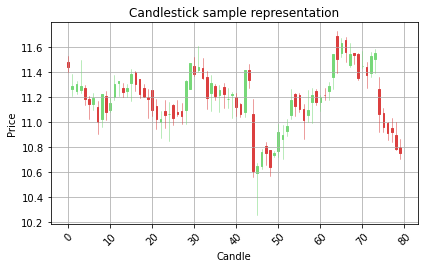

Correct trend is Bullish
Model prediction trend is Bearish
LOST


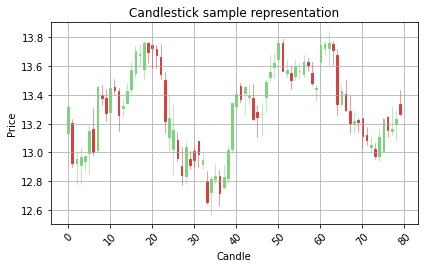

Correct trend is Bullish
Model prediction trend is Bullish
WON


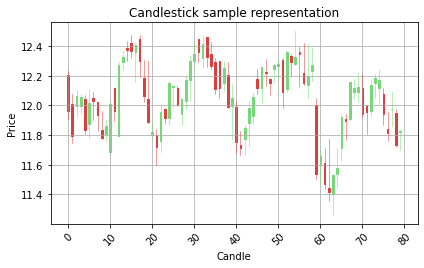

Correct trend is Bullish
Model prediction trend is Bullish
WON


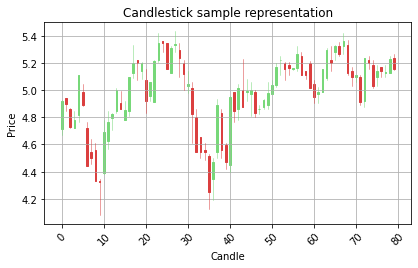

Correct trend is Bearish
Model prediction trend is Bearish
WON


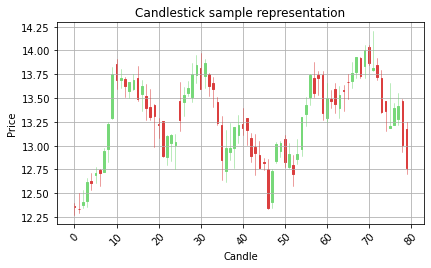

Correct trend is Bearish
Model prediction trend is Bearish
WON


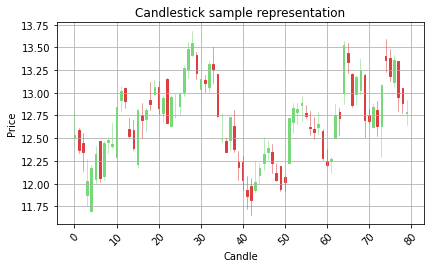

Correct trend is Bullish
Model prediction trend is Bearish
LOST


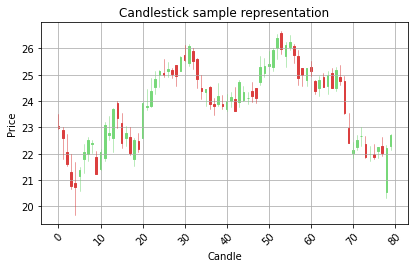

Correct trend is Bullish
Model prediction trend is Bullish
WON


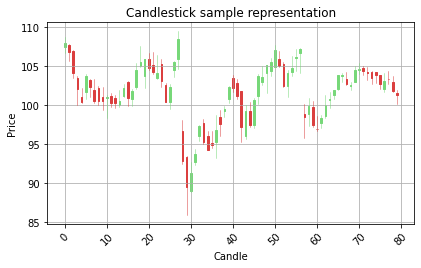

Correct trend is Bearish
Model prediction trend is Bearish
WON


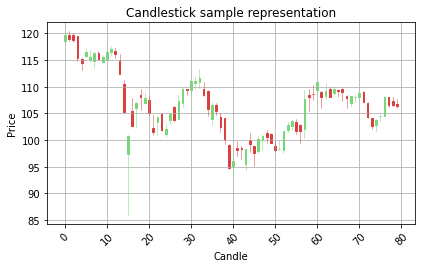

Correct trend is Bearish
Model prediction trend is Bullish
LOST


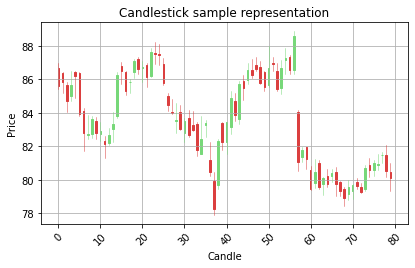

Correct trend is Bullish
Model prediction trend is Bullish
WON


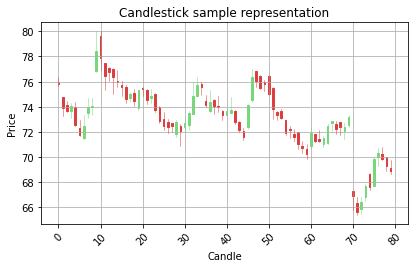

Correct trend is Bearish
Model prediction trend is Bullish
LOST


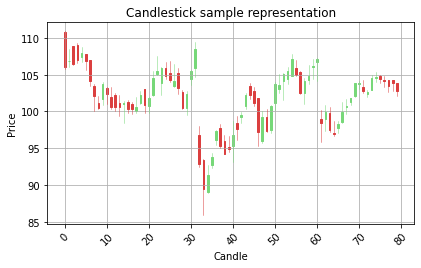

Correct trend is Bullish
Model prediction trend is Bearish
LOST


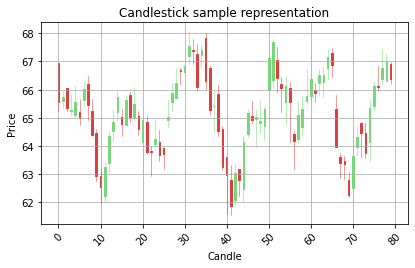

Correct trend is Bullish
Model prediction trend is Bearish
LOST


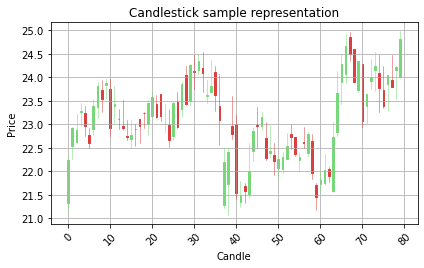

Correct trend is Bearish
Model prediction trend is Bearish
WON


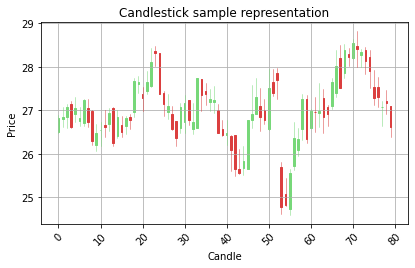

Correct trend is Bearish
Model prediction trend is Bullish
LOST


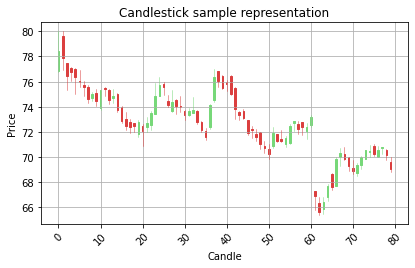

Correct trend is Bullish
Model prediction trend is Bearish
LOST


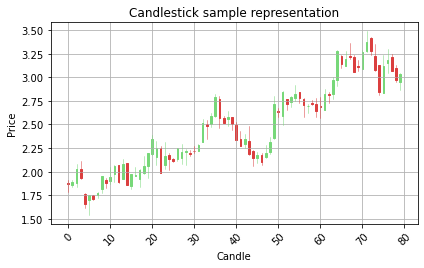

Correct trend is Bullish
Model prediction trend is Bearish
LOST


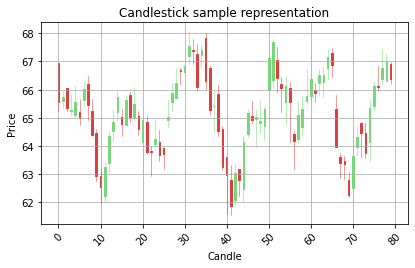

Correct trend is Bullish
Model prediction trend is Bullish
WON


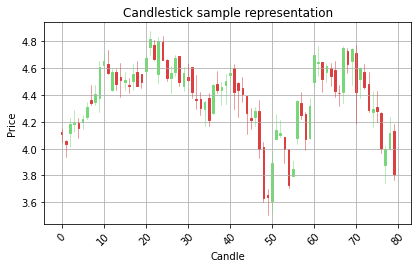

Correct trend is Bullish
Model prediction trend is Bearish
LOST


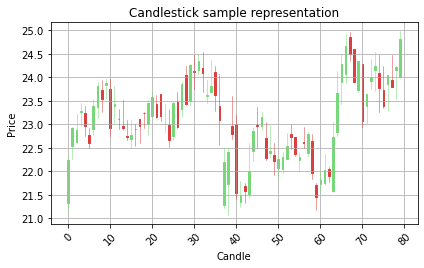

Correct trend is Bearish
Model prediction trend is Bearish
WON


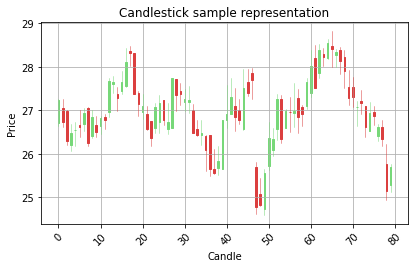

Correct trend is Bearish
Model prediction trend is Bullish
LOST


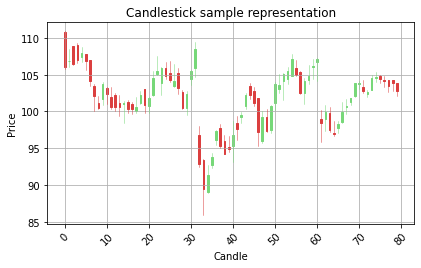

Correct trend is Bullish
Model prediction trend is Bearish
LOST


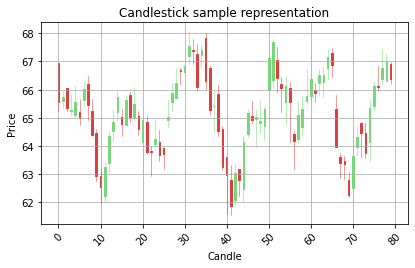

Correct trend is Bearish
Model prediction trend is Bullish
LOST


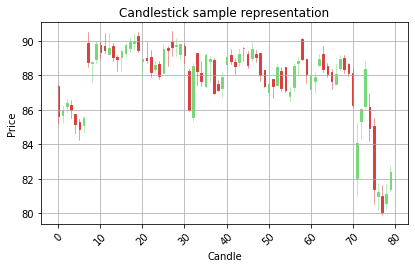

Correct trend is Bullish
Model prediction trend is Bearish
LOST


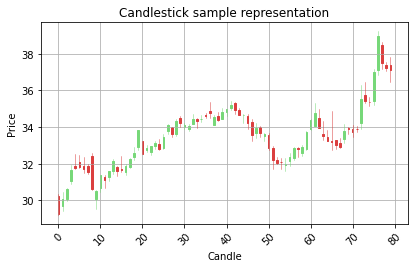

Correct trend is Bearish
Model prediction trend is Bullish
LOST


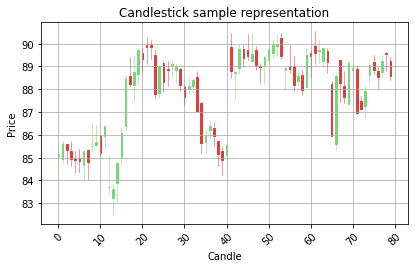

Correct trend is Bullish
Model prediction trend is Bullish
WON


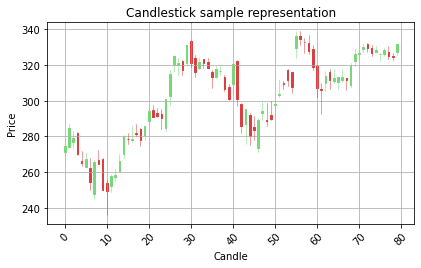

Correct trend is Bearish
Model prediction trend is Bullish
LOST


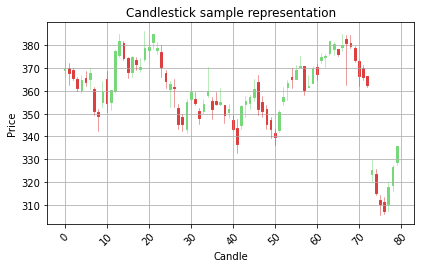

Correct trend is Bullish
Model prediction trend is Bearish
LOST


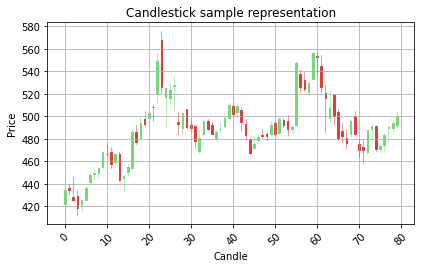

Correct trend is Bullish
Model prediction trend is Bullish
WON


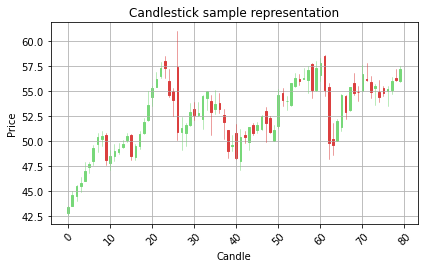

Correct trend is Bullish
Model prediction trend is Bullish
WON


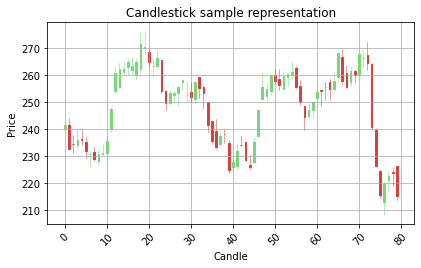

Correct trend is Bullish
Model prediction trend is Bearish
LOST


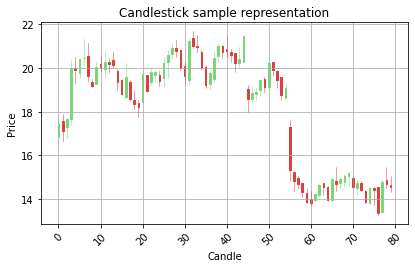

Correct trend is Bullish
Model prediction trend is Bearish
LOST


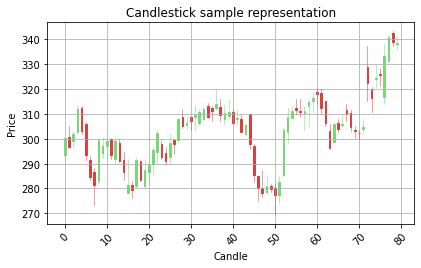

Correct trend is Bullish
Model prediction trend is Bullish
WON


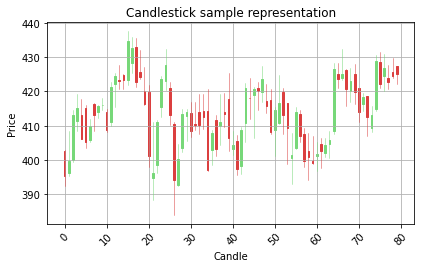

Correct trend is Bullish
Model prediction trend is Bearish
LOST


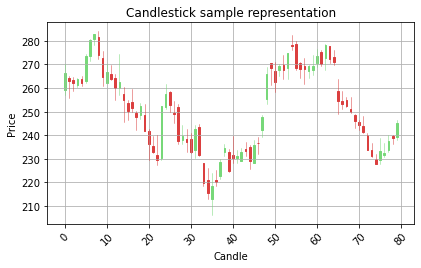

Correct trend is Bullish
Model prediction trend is Bearish
LOST


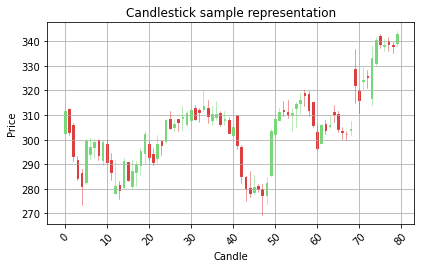

Correct trend is Bearish
Model prediction trend is Bullish
LOST


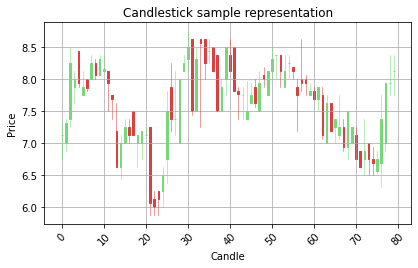

Correct trend is Bullish
Model prediction trend is Bullish
WON


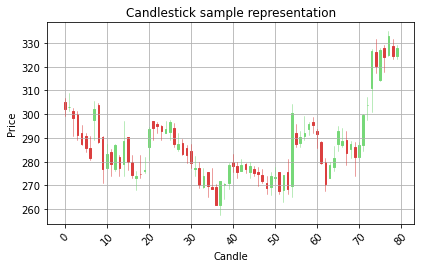

Correct trend is Bullish
Model prediction trend is Bearish
LOST


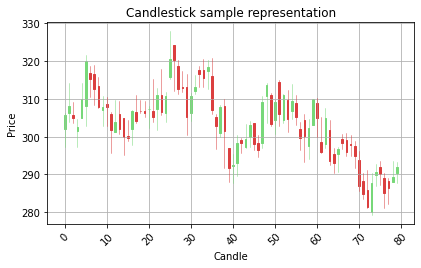

Correct trend is Bullish
Model prediction trend is Bearish
LOST


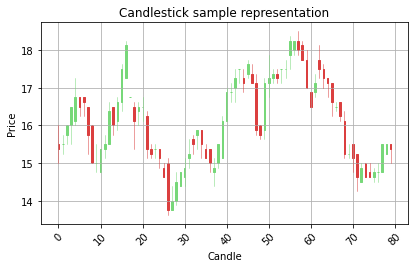

Won: 18 Lost: 26
Success rate: 40.91%


In [38]:

counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:print('Correct trend is Bullish')
        if Y_test[counter] == 0:print('Correct trend is Bearish')
        if a > (1-alpha_distance):print('Model prediction trend is Bullish')
        if a < alpha_distance:print('Model prediction trend is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 0 ,4))

        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        

        graph_data_ohlc(d_arr)

    counter=counter+1
    
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
